In [1]:
!pip uninstall tensorflow tensorflow_gpu protobuf --yes

Uninstalling tensorflow-1.4.0:
  Successfully uninstalled tensorflow-1.4.0
Cannot uninstall requirement tensorflow-gpu, not installed
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install tensorflow_gpu

    100% |████████████████████████████████| 253.3MB 5.0kB/s eta 0:00:01  9% |███                             | 24.3MB 59.0MB/s eta 0:00:04    28% |█████████                       | 71.0MB 36.3MB/s eta 0:00:06    86% |███████████████████████████▋    | 218.8MB 61.2MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 9.1MB/s eta 0:00:01
    100% |████████████████████████████████| 3.3MB 383kB/s eta 0:00:01
    100% |████████████████████████████████| 9.3MB 145kB/s eta 0:00:01
    100% |████████████████████████████████| 1.1MB 584kB/s eta 0:00:01
  Running setup.py bdist_wheel for termcolor ... done
  Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Running setup.py bdist_wheel for absl-py ... done
  Stored in directory: /root/.cache/pip/wheels/4c/16/ef/e36a23f2432e9220f8845f94e2c3abd39e7d9d1cd458d3159d
  Running setup.py bdist_wheel for gast ... done
  Stored in directory: /root/.cache/pip/wheels/9a/1f/0e/3cde98113222b853

In [3]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as norm
%matplotlib inline 

tfd = tf.contrib.distributions
tfn = tf.contrib.rnn
tfl = tf.linalg
dynrnn = tf.nn.dynamic_rnn

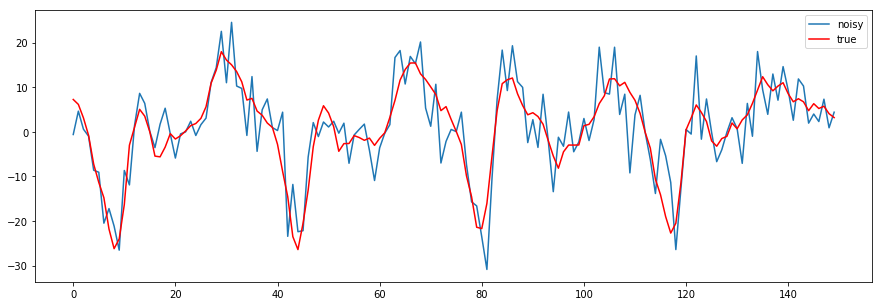

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softplus(x):
    return np.log(1 + np.exp(x)) + 1e-5

np.random.seed(1)
H = 140; T = 300; N = 1000; training_size = 900
h = np.zeros((N, T + 1, H)); 
h[:, 0, :] = np.zeros((N, H))
y = np.zeros((N, T + 1, 1)); y[:, 0] = np.zeros((N, 1))
sigma_c = 5.3
sigma_b = 1.5

A = 0.8 * np.random.randn(H, H)
R = scipy.linalg.expm(A - A.T)
B = 0.2 * np.random.randn(1, H)
b = 1 * np.random.randn(H, 1)
c = 2 * np.random.randn(H, 1)
bias_h = np.random.rand(1, H)
d = 0.01 * np.random.rand(H, 1)

for i in range(1, T + 1):
    h[:, i, :] = np.tanh(np.dot(h[:, i-1, :], R) + np.dot(y[:, i-1], B)) + 0.7 * h[:, i-1, :] + bias_h
    y[:, i] = (1 * np.dot(h[:, i, :], b) + np.tanh(np.dot(h[:, i, :], c)) - 1 
               + 3 * softplus(np.tanh(np.dot(h[:, i, :], d)) - 2) *
#                + sigma_b * 
               np.random.randn(N, 1))

y = y[:, 1:]
y = y - np.mean(y, 1, keepdims=True)
fig, ax = plt.subplots(1,1,figsize=(15, 5))
y_tilde = (y 
           + (20 * np.maximum(0, sigmoid(np.abs(y)) - 0.7) + 0.1) 
           * np.random.randn(N, T, 1))

seq_length = 150
training_data = y_tilde[:training_size]
testing_data = y_tilde[training_size:]

plt.plot(y_tilde[0, 50:200], label='noisy');
plt.plot(y[0, 50:200], 'r', label='true');
plt.legend();

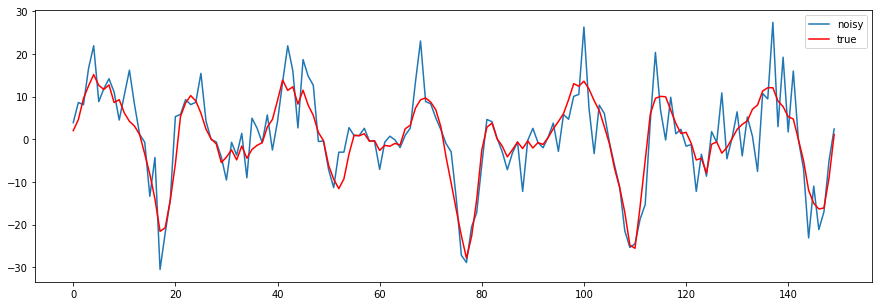

In [5]:
idx = np.random.randint(0, 100)
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[idx, 50:200], label='noisy');
plt.plot(y[idx, 50:200], 'r', label='true');
plt.legend();

In [6]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [7]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, std=None, reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        if std is not None:
            self._std = std[None, None]
        else:
            self._layer_1 = tf.layers.Dense(100, tf.nn.relu)
            self._layer_sigma = tf.layers.Dense(self._event_size, tf.nn.softplus)

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        mean = tf.layers.dense(hidden, self._event_size)
        try: 
            std = self._layer_sigma(self._layer_1(hidden)) + 1e-5
            return (mean, std), state
        except AttributeError:
            n_samples = mean.shape[0]
            return (mean, tf.tile(self._std, (n_samples, self._event_size))), state
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.MultivariateNormalDiag(mean, std).sample()
        return (mean, std, sample), (state, sample)
    
class BeamSamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a Beam Search sequence in autoregressive mode by sampling and pruning
    at every step
    """
    
    def __init__(self, cell, output_size, branch_width, reuse=None):
        super(BeamSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._branch_width = branch_width
        
    @property
    def state_size(self):
        (self._cell.state_size, self._output_size, 1)
        
    @property
    def output_size(self):
        return (self._output_size, self._output_size)
    
    def call(self, _, state_and_sample_and_prob):
        (state, sample, probs) = state_and_sample_and_prob
        (mean, std), state = self._cell(sample, state)
        dist = tfd.MultivariateNormalDiag(mean, std)
        sample = dist.sample((self._branch_width))
        new_probs = dist.log_prob(sample)
        new_probs = tf.reshape(new_probs, [-1])
        probs = tf.reshape(tf.tile(probs[None, ..., 0], [self._branch_width, 1]), [-1])
        best_probs, best_idx = tf.nn.top_k(new_probs + probs, k=self._branch_width)
        best_samples = tf.gather(tf.reshape(sample, [-1, self._output_size]), best_idx)
        
        return (mean, best_samples), (state, best_samples, best_probs[..., None])

In [ ]:
class StandardRNN(object):
    """
    First baseline
    """
    
    def __init__(self, data, n_hidden, seq_length, batch_size):
        self._B = batch_size                                      # B
        self._T = seq_length                                      # T
        self._D = 1                                               # D
        self._H = n_hidden                                        # H
        self._data = data                                         # B x T x D
        
        self.initialise_variables
        self.compute_cost_func
        self.optimise
        
    @define_scope
    def initialise_variables(self):
        self._cell = tfn.GRUBlockCell(self._H)
        self._optimiser = tf.train.AdamOptimizer(0.001)
        
    @define_scope
    def compute_cost_func(self):
        inputs = tf.concat([tf.zeros((self._B, 1, self._D)), self._data[:, :-1]], 1)
        outputs, _ = dynrnn(self._cell, inputs=inputs, dtype=tf.float32)
        return tf.reduce_sum(tf.square(outputs - self._data))
    
    @define_scope
    def optimise(self):
        gradients, variables = zip(*self._optimiser.compute_gradients(self.compute_cost_func))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))

In [ ]:
tf.reset_default_graph()

batch_size = 20;
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

rnn = StandardRNN(x_, n_hidden=30, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

try:
    tf.train.Saver().restore(sess, "./rnn1.ckpt")
    
except Exception:
    
    mses = []; test_mses = []
    
    for i in range(100001):
        idx = np.random.randint(0, training_size, batch_size)
        batch = training_data[idx, :seq_length]
        
        if i % 1000 == 0:
            mse = sess.run(rnn.compute_cost_func, {x_: batch})
            mses.append(mse)
        
        if i % 5000 == 0:
            idx = np.random.randint(0, N - training_size, batch_size)
            batch = testing_data[idx, :seq_length]
            test_mse = sess.run(rnn.compute_cost_func, {x_: batch})
            test_mses.append(test_mse)
            print('Iteration:', i, 'Test MSE:', test_mse)
        
        if i % 10000 == 0:
            print('Iteration:', i, 'MSE:', mse)

        sess.run(rnn.optimise, {x_: batch})
        
    tf.train.Saver().save(sess, './rnn.ckpt')

In [ ]:
class SequenceVAE(object):
    """
    Second baseline
    """
    
    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size):
        self._B = batch_size                                      # B
        self._T = seq_length                                      # T
        self._D = 1                                               # D
        self._H = n_hidden                                        # H
        self._Sz = n_samples                                      # Sz
        self._Z = 20                                              # Z
        self._data = data                                         # B x T x D
        self._branch_width = 5
        
        self.initialise_variables
        self.q_z = self.make_encoder
        self.p_y = self.make_decoder
        self.compute_elbo
        self.optimise
        self.predict_forward_beam
        
    @define_scope
    def initialise_variables(self):
        self._cell = tfn.GRUBlockCell(self._H)
        self._gauss_cell = GaussianCell(self._cell, self._D)
        self._beam_cell = BeamSamplingCell(self._gauss_cell, self._D, self._branch_width)
        self._post_cell = tfn.GRUBlockCell(self._H)
        self._layer = tf.layers.Dense(self._H, tf.nn.relu)
        self._optimiser = tf.train.AdamOptimizer(0.001)
     
    @define_scope
    def make_encoder(self):
        _, h = dynrnn(self._post_cell, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus) + 1e-5
        posterior_z = tfd.MultivariateNormalDiag(means, stds)
        return posterior_z
    
    @define_scope
    def make_kl_z(self):
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(self.q_z, p))
    
    @define_scope
    def make_decoder(self):
        self._code_z = self.q_z.sample((self._Sz))
        hidden = self._layer(tf.reshape(self._code_z, [-1, self._Z]))                         # (Sz * B) x H
        data = tf.reshape(tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1)), [-1, self._T, self._D])
        inputs = tf.concat([tf.zeros((self._B * self._Sz, 1, self._D)), data[:, :-1]], 1)
        (means, stds), h = dynrnn(self._gauss_cell, inputs=inputs, initial_state=hidden)
        means = tf.identity(means, name='means')
        stds = tf.identity(stds, name='stds')
        return tfd.MultivariateNormalDiag(means, stds)
    
    @define_scope
    def make_reconstruction(self):
        data = tf.reshape(tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1)), [-1, self._T, self._D])
        return tf.reduce_sum(self.p_y.log_prob(data))/self._Sz
    
    @define_scope
    def compute_elbo(self):
        kl_z = self.make_kl_z        
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl_z        
        return loss, kl_z, reconstruction
    
    @define_scope
    def optimise(self):
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0]))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def predict_forward_beam(self):
        code_z = self.q_z.sample()[:1]
        hidden = self._layer(code_z)
        inputs = self._data[:1]
        _, h = dynrnn(self._cell, inputs=inputs, initial_state=hidden)
        fake_inputs = tf.zeros((self._branch_width, 30, self._D))
        state_and_sample_and_prob = (tf.tile(h, [self._branch_width, 1]), 
                                     tf.tile(inputs[:, -1], [self._branch_width, 1]), 
                                     tf.zeros((self._branch_width, 1)))
        
        (_, samples), (_, _, probs) =\
            dynrnn(self._beam_cell, inputs=fake_inputs, initial_state=state_and_sample_and_prob)
            
        best_idx = tf.argmax(probs)
        return tf.gather(samples, best_idx)

In [ ]:
tf.reset_default_graph()

n_samples = 100; batch_size = 20
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

seq_vae = SequenceVAE(x_, n_hidden=30, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

try:
    tf.train.Saver().restore(sess, "./seq_vae1.ckpt")
    
except Exception:
    
    vae_elbos = []; vae_kls_z = []; vae_llks = []; vae_test_elbos = []
    
    for i in range(100001):
        idx = np.random.randint(0, training_size, batch_size)
        batch = training_data[idx, :seq_length]
        
        if i % 1000 == 0:
            elbo, kl_z, llk = sess.run(seq_vae.compute_elbo, {x_: batch})
            vae_elbos.append(elbo); vae_kls_z.append(kl_z); vae_llks.append(llk)
        
        if i % 5000 == 0:
            idx = np.random.randint(0, N - training_size, batch_size)
            batch = testing_data[idx, :seq_length]
            test_elbo, _, _ = sess.run(seq_vae.compute_elbo, {x_: batch})
            vae_test_elbos.append(test_elbo)
            print('Iteration:', i, 'Test ELBO:', test_elbo)
            
        if i % 10000 == 0:
            print('Iteration:', i, 'ELBO:', elbo, 'KL (z):', kl_z, 'Reconstruction:', llk)

        sess.run(seq_vae.optimise, {x_: batch})
        
    tf.train.Saver().save(sess, './seq_vae.ckpt')

Iteration: 0 Test elbo: -554785.0
Iteration: 0 ELBO: -526838.0 KL (z): 92.1021 Reconstruction: -526746.0


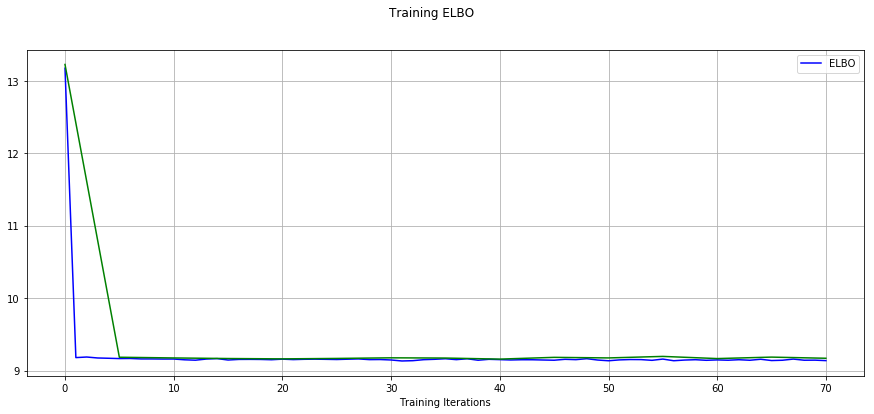

In [33]:
# New plot
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(np.log([-e for e in vae_elbos]), 'b', label='ELBO')
plt.plot([5 * t for t in range(len(vae_test_elbos))], np.log([-e for e in vae_test_elbos]), 'g')
# plt.plot(vae_llks, 'orange', label='Reconstruction')
# plt.plot(vae_kls_z, label='KL')
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
plt.legend();
# plt.savefig('seq-vae-elbo.pdf', bbox_inches='tight')

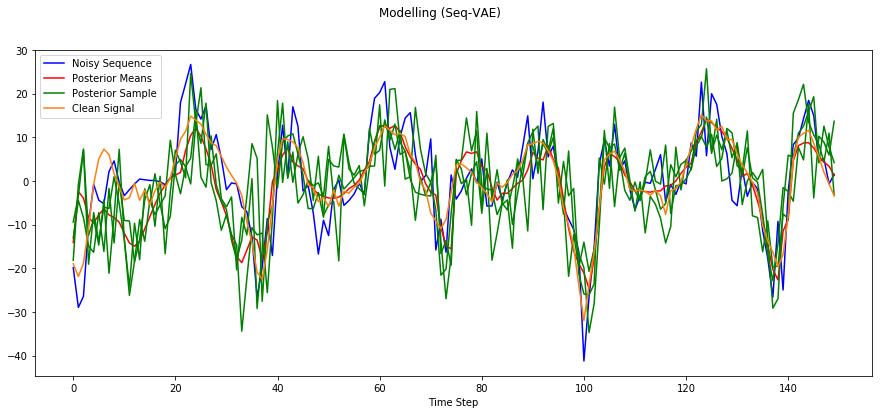

In [18]:
np.random.seed(0)
testing_data = y_tilde[training_size:, 70:70+seq_length]
idx = np.random.randint(0, y_tilde.shape[0] - training_size, batch_size)
batch = testing_data[idx, ...]

trans_means_op = tf.get_default_graph().get_tensor_by_name('make_decoder/means:0')
means = sess.run(trans_means_op, {x_: batch})
samples = sess.run(seq_vae.p_y.sample(), {x_: batch})

# np.random.seed(0)
i = np.random.randint(0, batch_size)
plt.subplots(1,1,figsize=(15,6))
plt.plot(batch[i, :], 'b', label='Noisy Sequence')
plt.plot(np.mean(np.reshape(means, (n_samples, batch_size, seq_length, 1)), 0)[i], 'r-', label='Posterior Means')
plt.plot(np.reshape(samples, (n_samples, batch_size, seq_length))[1, i] , 'g', label='Posterior Sample')
plt.plot(np.reshape(samples, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(samples, (n_samples, batch_size, seq_length))[2, i] , 'g')
plt.plot([], [])
plt.plot(y[training_size + idx[i], 70:70+seq_length], label='Clean Signal')
plt.xlabel('Time Step')
plt.suptitle('Modelling (Seq-VAE)')
plt.legend();
# plt.savefig('seq-vae-modelling.pdf', bbox_inches='tight')

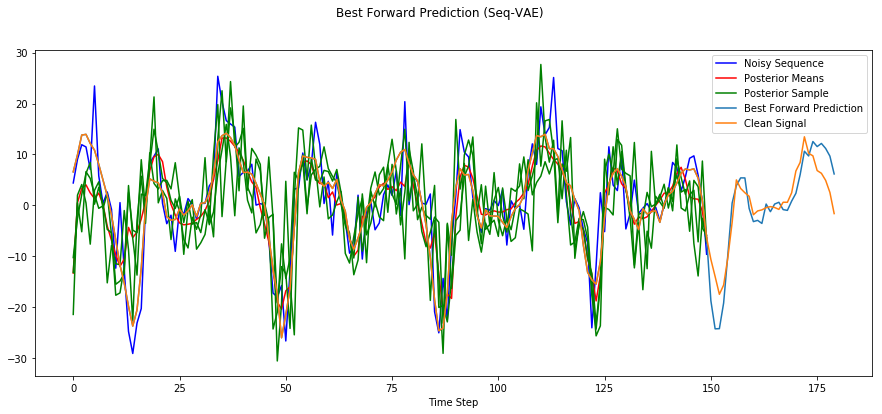

In [19]:
i = 0
plt.subplots(1,1,figsize=(15,6))
plt.plot(batch[i, :], 'b', label='Noisy Sequence')
plt.plot(np.mean(np.reshape(means, (n_samples, batch_size, seq_length, 1)), 0)[i], 'r-', label='Posterior Means')
plt.plot(np.reshape(samples, (n_samples, batch_size, seq_length))[1, i] , 'g', label='Posterior Sample')
plt.plot(np.reshape(samples, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(samples, (n_samples, batch_size, seq_length))[2, i] , 'g')

continuation = sess.run(seq_vae.predict_forward_beam, {x_: batch})

plt.plot(np.concatenate([y[training_size + idx[i], 70:70+seq_length], continuation[0]], 0),
         label='Best Forward Prediction')
plt.plot(y[training_size + idx[i], 70:70+seq_length+30], label='Clean Signal')
plt.legend()
plt.xlabel('Time Step')
plt.suptitle("Best Forward Prediction (Seq-VAE)");
# plt.savefig('seq-vae-prediction.pdf', bbox_inches='tight')

In [ ]:
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size):
        self._data = data                                         # B x T x D
        self._B = batch_size                                      # B
        self._T = seq_length                                      # T
        self._D = 1                                               # D
        self._H = n_hidden                                        # H
        self._Sz = n_samples                                      # Sz
        self._Z = 20                                              # Z
        
        self.initialise_variables
        self.q_z = self.make_posterior_z
        self.p_y = self.make_transitional
        self.compute_elbo
        self.optimise
        
        self.make_forward_posterior
        self.make_forward_parameters
        self.compute_elbo_forward
        self.forward_E_step
        self.forward_M_step
    
    @define_scope
    def initialise_variables(self):
        self._cell = tfn.GRUBlockCell(self._H)
        self._gauss_cell = GaussianCell(self._cell, self._D)
        self._sampling_cell = SamplingCell(self._gauss_cell, self._D)
        self._layer = tf.layers.Dense(self._H, tf.nn.relu)
        self._layer1 = tf.layers.Dense(5, tf.nn.relu)
        self._layer2 = tf.layers.Dense(self._D, tf.nn.softplus)
        self._post_cell_z = tfn.GRUBlockCell(self._H)
        self._optimiser = tf.train.AdamOptimizer(0.001)
    
    @define_scope
    def make_posterior_z(self):
        _, h = dynrnn(self._post_cell_z, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus) + 1e-5
        posterior_z = tfd.MultivariateNormalDiag(means, stds)
        return posterior_z
    
    @define_scope
    def make_kl_z(self):
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(self.q_z, p))
    
    @define_scope
    def make_transitional(self):
        self._code_z = self.q_z.sample((self._Sz))
        hidden = self._layer(tf.reshape(self._code_z, [-1, self._Z]))                         # (Sz * B) x H
        state_and_sample = (hidden, tf.zeros((self._B * self._Sz, self._D)))
        inputs = tf.zeros((self._B * self._Sz, self._T, self._D))
        (means, stds, self._code_y), _ = dynrnn(self._sampling_cell, initial_state=state_and_sample, inputs=inputs)
        means = tf.identity(means, name='means')
        stds = tf.identity(stds, name='stds')
        return tfd.MultivariateNormalDiag(means, stds)
    
    @define_scope
    def make_reconstruction(self):
        stds = self._layer2(self._layer1(self._code_y)) + 1e-5
        gen_prob = tfd.MultivariateNormalDiag(self._code_y, stds)
        data = tf.reshape(tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1)), [-1, self._T, self._D])
        return tf.reduce_sum(gen_prob.log_prob(data))/self._Sz
    
    @define_scope
    def compute_elbo(self):
        kl_z = self.make_kl_z        
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl_z
        
        return loss, kl_z, reconstruction

    @define_scope
    def optimise(self):
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0]))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def make_forward_posterior(self):
        y_mu = tf.get_variable(shape=(self._T, self._D), name='forward_y_mean', initializer=tf.constant_initializer(0))
        y_sigma = tf.nn.softplus(tf.get_variable(shape=(self._T, self._D), initializer=tf.constant_initializer(2), 
                                                 name='forward_y_std'))
        
        z_mu = tf.get_variable(shape=(self._Z), name='forward_z_mean', initializer=tf.constant_initializer(10))
        z_sigma = tf.nn.softplus(tf.get_variable(shape=(self._Z), initializer=tf.constant_initializer(1), 
                                                 name='forward_z_std'))
        
        dist_z = tfd.MultivariateNormalDiag(z_mu, z_sigma)
        dist_y = tfd.MultivariateNormalDiag(y_mu, y_sigma)
        return dist_z, dist_y

    @define_scope
    def make_forward_parameters(self):
        return tf.get_variable(shape=(30, self._D), name='best_forward_sequence', 
                               initializer=tf.constant_initializer(0))
    
    @define_scope
    def make_rnn_forward(self):
        (dist_z, dist_y) = self.make_forward_posterior
        code_z = dist_z.sample((self._Sz))
        code_y = dist_y.sample((self._Sz))
        inputs = tf.concat([tf.zeros((self._Sz, 1, self._D)), code_y[:, :-1]], 1)        
        _, hT = dynrnn(self._cell, inputs, initial_state=self._layer(code_z))
        
        fake_inputs = tf.zeros((self._Sz, 30, self._D))
        (means, stds, _), _ = dynrnn(self._sampling_cell, inputs=fake_inputs, initial_state=(hT, code_y[:, -1]))
        return tfd.MultivariateNormalDiag(means, stds)
    
    @define_scope
    def make_forward_kl(self):
        (post_z, post_y) = self.make_forward_posterior
        
        kl_z = tfd.kl_divergence(post_z, self.q_z)
        kl_y = tfd.kl_divergence(post_y, self.p_y)
        
        return kl_z[0], tf.reduce_sum(tf.reshape(kl_y, [self._Sz, self._B, self._T])[:, 0])/self._Sz
    
    @define_scope
    def make_forward_reconstruction(self):
        pred = self.make_forward_parameters
        return tf.reduce_sum(self.make_rnn_forward.log_prob(pred[None, ...]))/self._Sz
    
    @define_scope
    def compute_elbo_forward(self):
        (kl_z, kl_y) = self.make_forward_kl
        reconstruction = self.make_forward_reconstruction        
        return reconstruction - kl_z - kl_y
    
    @define_scope
    def forward_E_step(self):
        var_e = [v for v in tf.trainable_variables() if 'make_forward_posterior' in v.name]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo_forward, var_list=var_e))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def forward_M_step(self):
        var_m = [v for v in tf.trainable_variables() if 'make_forward_parameters' in v.name]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo_forward, var_list=var_m))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))

In [ ]:
tf.reset_default_graph()

n_samples = 500; batch_size = 20;

x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

gen_model = RobustARGenerator(x_, n_hidden=30, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' not in v.name])

try:
    saver.restore(sess, "./robust_model1.ckpt")
    sess.run(tf.variables_initializer([v for v in tf.global_variables() if 'forward' in v.name]))
    
except Exception:
    
    sess.run(tf.global_variables_initializer())
    elbos = []; kls_z = []; llks = []; test_elbos = []
    
    for i in range(100001):
        idx = np.random.randint(0, training_size, batch_size)
        batch = training_data[idx, :seq_length]
        
        if i % 1000 == 0:
            elbo, kl_z, llk = sess.run(gen_model.compute_elbo, {x_: batch})
            elbos.append(elbo); kls_z.append(kl_z); llks.append(llk)
        
        if i % 5000 == 0:
            idx = np.random.randint(0, N - training_size, batch_size)
            batch = testing_data[idx, :seq_length]
            test_elbo, _, _ = sess.run(gen_model.compute_elbo, {x_: batch})
            test_elbos.append(test_elbo)
            print('Iteration:', i, 'Test elbo:', test_elbo)
            
        if i % 5000 == 0:
            print('Iteration:', i, 'ELBO:', elbo, 'KL (z):', kl_z, 'Reconstruction:', llk)

        sess.run(gen_model.optimise, {x_: batch})
        
    saver.save(sess, './robust_model.ckpt')

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updatin

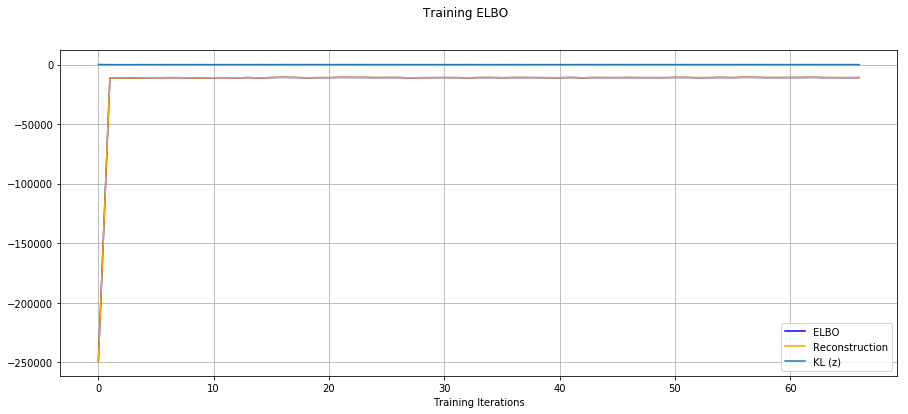

In [10]:
# New plot
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(llks, 'orange', label='Reconstruction')
plt.plot(kls_z, label='KL (z)')
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
plt.legend();

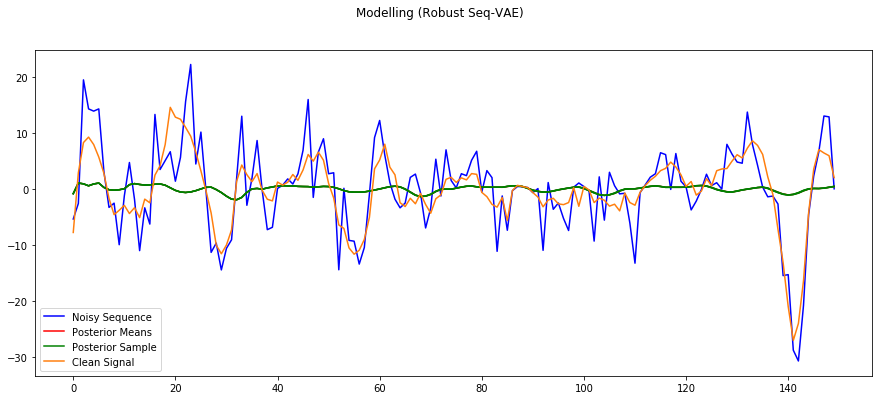

In [13]:
np.random.seed(0)
testing_data = y_tilde[training_size:, 50:50+seq_length]
idx = np.random.randint(0, y_tilde.shape[0] - training_size, batch_size)
batch = testing_data[idx, ...]

trans_means_op = tf.get_default_graph().get_tensor_by_name('make_transitional/means:0')
means = sess.run(trans_means_op, {x_: batch})
latents = sess.run(gen_model._code_y, {x_: batch})

np.random.seed(0)
i = np.random.randint(0, batch_size)
plt.subplots(1,1,figsize=(15,6))
plt.plot(batch[i, :], 'b', label='Noisy Sequence')
plt.plot(np.mean(np.reshape(means, (n_samples, batch_size, seq_length, 1)), 0)[i], 'r-', label='Posterior Means')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[1, i] , 'g', label='Posterior Sample')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[2, i] , 'g')
plt.plot([], [])
plt.plot(y[training_size + idx[i], 50:50+seq_length], label='Clean Signal')
plt.suptitle('Modelling (Robust Seq-VAE)')
plt.legend();
# plt.savefig('robust-seq-vae-modelling.pdf', bbox_inches='tight')

In [ ]:
elbos_forward = [];

for i in range(30001):   
    elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: batch})
    sess.run(gen_model.forward_E_step, {x_: batch})
    sess.run(gen_model.forward_M_step, {x_: batch})
    
    elbos_forward.append(elbo_forward)
    
    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO Forward:', elbo_forward)

In [ ]:
i = 0
plt.plot(batch[i, :], 'b', label='Noisy Sequence')
plt.plot(np.mean(np.reshape(means, (n_samples, batch_size, seq_length, 1)), 0)[i], 'r-', label='Posterior Means')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[1, i] , 'g', label='Posterior Sample')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[2, i] , 'g')

continuation = sess.run(gen_model.make_forward_parameters, {x_: batch})
plt.plot(np.concatenate([y[idx[i], 50:50+seq_length], continuation], 0), label='Best Forward Prediction')
plt.plot(y[training_size + idx[i], 70:70+seq_length+30], label='Clean Signal')
plt.legend()
plt.xlabel('Time Step')
plt.suptitle("Best Forward Prediction (Robust Seq-VAE)");
plt.savefig('robust-seq-vae-prediction.pdf', bbox_inches='tight')